## Fine Tuning BERT for Multi Class Sentiment Classification

In [ ]:
!pip install -U transformers
!pip install -U accelerate
!pip install -U datasets
!pip install -U bertviz
!pip install -U umap-learn
!pip install seaborn --upgrade

### Import the Data

In [2]:
import pandas as pd
df = pd.read_csv("https://raw.githubusercontent.com/laxmimerit/All-CSV-ML-Data-Files-Download/master/twitter_multi_class_sentiment.csv")
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   text        16000 non-null  object
 1   label       16000 non-null  int64 
 2   label_name  16000 non-null  object
dtypes: int64(1), object(2)
memory usage: 375.1+ KB


In [4]:
df.isnull().sum()

,0
text,0
label,0
label_name,0


In [5]:
df['label'].value_counts()

,count
label,
1,5362
0,4666
3,2159
4,1937
2,1304
5,572


### Exploratory Data Analysis

In [6]:
import matplotlib.pyplot as plt


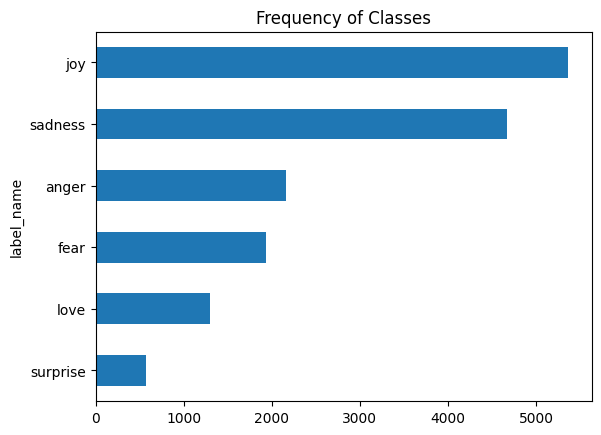

In [7]:
label_counts = df['label_name'].value_counts(ascending=True)
label_counts.plot.barh()
plt.title("Frequency of Classes")
plt.show()

In [8]:
df['Words per Tweet'] = df['text'].str.split().apply(len)

<Axes: title={'center': 'Words per Tweet'}, xlabel='label_name'>

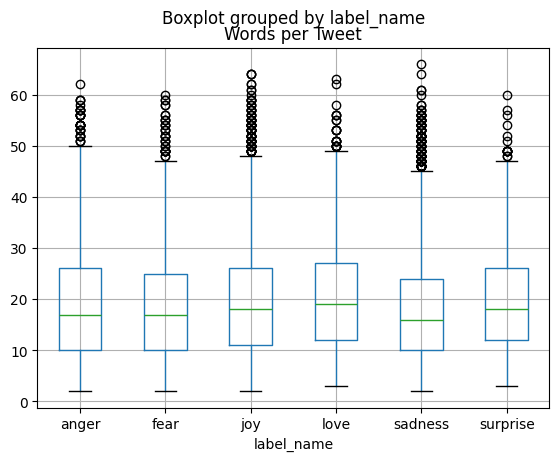

In [9]:
df.boxplot("Words per Tweet", by="label_name")

### Tokenization

In [10]:
from transformers import AutoTokenizer

model_name = "bert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [11]:
text = "I want to be a AI/ML Engineer"
encoded_text = tokenizer(text)
print(encoded_text)

{'input_ids': [101, 146, 1328, 1106, 1129, 170, 19016, 120, 150, 2162, 8252, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [12]:
tokenizer.vocab_size, tokenizer.model_max_length

(28996, 512)

### Train Test Split

In [13]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.3, stratify=df['label'])
test, validation = train_test_split(test_df, test_size=1/3, stratify=test_df['label'])

train_df.shape, test_df.shape, validation.shape

((11200, 4), (4800, 4), (1600, 4))

In [14]:
from datasets import Dataset, DatasetDict

dataset = DatasetDict(
    {
        'train': Dataset.from_pandas(train_df, preserve_index=False),
        'test': Dataset.from_pandas(test_df, preserve_index=False),
        'validation': Dataset.from_pandas(validation, preserve_index=False)
    }
)

dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_name', 'Words per Tweet'],
        num_rows: 11200
    })
    test: Dataset({
        features: ['text', 'label', 'label_name', 'Words per Tweet'],
        num_rows: 4800
    })
    validation: Dataset({
        features: ['text', 'label', 'label_name', 'Words per Tweet'],
        num_rows: 1600
    })
})

### Tokenize the Data

In [15]:
dataset['train'][0]

{'text': 'i write on my blog here that i want or i am going to do something i feel more pressured for want of a better word to do it',
 'label': 4,
 'label_name': 'fear',
 'Words per Tweet': 29}

In [16]:
dataset['train'][1]

{'text': 'im feeling suitably annoyed by the panel and its time to get you a recipe for these previously deemed unworthy treats',
 'label': 3,
 'label_name': 'anger',
 'Words per Tweet': 21}

In [17]:
def tokenize(batch):
  temp = tokenizer(batch['text'], padding=True, truncation=True)
  return temp

print(tokenize(dataset['train'][:2]))

{'input_ids': [[101, 178, 3593, 1113, 1139, 10679, 1303, 1115, 178, 1328, 1137, 178, 1821, 1280, 1106, 1202, 1380, 178, 1631, 1167, 2997, 1181, 1111, 1328, 1104, 170, 1618, 1937, 1106, 1202, 1122, 102], [101, 13280, 2296, 4228, 5382, 12049, 1118, 1103, 5962, 1105, 1157, 1159, 1106, 1243, 1128, 170, 20538, 1111, 1292, 2331, 8012, 8362, 13849, 20554, 102, 0, 0, 0, 0, 0, 0, 0]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]]}


In [18]:
emotion_encoded = dataset.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/11200 [00:00<?, ? examples/s]

Map:   0%|          | 0/4800 [00:00<?, ? examples/s]

Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

In [19]:
# label2id, id2label
label2id = {x['label_name']:x['label'] for x in dataset['train']}
id2label = {v:k for k,v in label2id.items()}

label2id, id2label

({'fear': 4, 'anger': 3, 'sadness': 0, 'joy': 1, 'love': 2, 'surprise': 5},
 {4: 'fear', 3: 'anger', 0: 'sadness', 1: 'joy', 2: 'love', 5: 'surprise'})

### Model Building

In [20]:
from transformers import AutoModel
import torch

In [21]:
model = AutoModel.from_pretrained(model_name)

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

In [22]:
model.config.id2label
model.config

BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "dtype": "float32",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.57.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28996
}

Fine Tuning Transformers

In [25]:
from transformers import AutoModelForSequenceClassification, AutoConfig


num_labels = len(label2id)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
config = AutoConfig.from_pretrained(model_name, label2id=label2id, id2label=id2label)
model = AutoModelForSequenceClassification.from_pretrained(model_name, config=config).to(device)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
model.config

BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "dtype": "float32",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "sadness",
    "1": "joy",
    "2": "love",
    "3": "anger",
    "4": "fear",
    "5": "surprise"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "anger": 3,
    "fear": 4,
    "joy": 1,
    "love": 2,
    "sadness": 0,
    "surprise": 5
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.57.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28996
}

In [28]:
from transformers import TrainingArguments

batch_size = 64
training_dir = "bert_base_train_df"

training_args = TrainingArguments(
    output_dir = training_dir,
    overwrite_output_dir = True,
    num_train_epochs = 2,
    learning_rate = 2e-5,
    per_device_train_batch_size = batch_size,
    per_device_eval_batch_size = batch_size,
    weight_decay = 0.01,
    disable_tqdm = False
)

In [29]:
# use sklearn to build compute metrics
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)

    return {"accuracy": acc, "f1": f1}

### Build and train model

In [30]:
from transformers import Trainer
trainer = Trainer(
    model = model,
    args = training_args,
    compute_metrics = compute_metrics,
    train_dataset = emotion_encoded['train'],
    eval_dataset = emotion_encoded['validation'],
    tokenizer = tokenizer

)

/tmp/ipython-input-1073123981.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [31]:
trainer.train()

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: nahid35-3155 (nahid35-3155-daffodil-international-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss


TrainOutput(global_step=350, training_loss=0.6812714494977679, metrics={'train_runtime': 445.5461, 'train_samples_per_second': 50.275, 'train_steps_per_second': 0.786, 'total_flos': 1082083076121600.0, 'train_loss': 0.6812714494977679, 'epoch': 2.0})

### Model Evaluation

In [32]:
preds_output = trainer.predict(emotion_encoded['test'])
preds_output.metrics

{'test_loss': 0.26054635643959045,
 'test_accuracy': 0.9152083333333333,
 'test_f1': 0.915455452989965,
 'test_runtime': 19.9468,
 'test_samples_per_second': 240.64,
 'test_steps_per_second': 3.76}

In [34]:
import numpy as np
y_pred = np.argmax(preds_output.predictions, axis=1)
y_true = emotion_encoded['test'][:]['label']

In [35]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.95      0.95      1400
           1       0.95      0.92      0.93      1608
           2       0.78      0.88      0.83       391
           3       0.91      0.91      0.91       648
           4       0.88      0.90      0.89       581
           5       0.87      0.74      0.80       172

    accuracy                           0.92      4800
   macro avg       0.89      0.88      0.88      4800
weighted avg       0.92      0.92      0.92      4800



In [36]:
label2id

{'fear': 4, 'anger': 3, 'sadness': 0, 'joy': 1, 'love': 2, 'surprise': 5}

In [37]:
# plot confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix

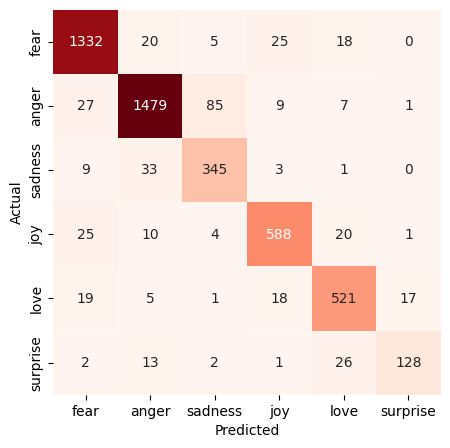

In [38]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, xticklabels=label2id.keys(), yticklabels=label2id.keys(), fmt='d', cbar=False, cmap='Reds')
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

### Build Prediction Function and Store Model

In [39]:
text = "I am super happy today. I got it done. Finally!!"

def get_prediction(text):
    input_encoded = tokenizer(text, return_tensors='pt').to(device)

    with torch.no_grad():
        outputs = model(**input_encoded)

    logits = outputs.logits

    pred = torch.argmax(logits, dim=1).item()
    return id2label[pred]

get_prediction(text)

'joy'

In [40]:
trainer.save_model("bert-base-uncased-sentiment-model")

In [41]:
# use pipeline for prediciton
from transformers import pipeline

classifier = pipeline('text-classification', model= 'bert-base-uncased-sentiment-model')

classifier([text, 'hello, how are you?', "love you", "i am feeling low"])

Device set to use cuda:0


[{'label': 'joy', 'score': 0.9715408086776733},
 {'label': 'joy', 'score': 0.768108606338501},
 {'label': 'love', 'score': 0.7449676990509033},
 {'label': 'sadness', 'score': 0.9689986705780029}]

### Save the model as zip file

In [42]:
import shutil

# Folder that contains model files
model_dir = "bert-base-uncased-sentiment-model"

# Create a zip file
shutil.make_archive(model_dir, 'zip', model_dir)


'/content/bert-base-uncased-sentiment-model.zip'

In [43]:
from google.colab import files
files.download("bert-base-uncased-sentiment-model.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>